In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Neuron ... n
# Input ... x
# Weight ... w ... hold by a synapse. The snyaptic strength for the input
# A synapse interacts with the input to the Neuron multiplicatively
# Flow ... F ... So what flows to the neuron is w * x
# There are multiple inputs
# Bias ... b ... trigger happiness
# Activiation Function ... f ... tanh or sigmoid. Also called squashing functions because it smoothly caps it out to -1 or +1.
# Out ... o ... What comes out of the neuron when the Activiation Function is applied to the sum of the Flows multiplied by the Bias.

In [3]:
from graphviz import Digraph

def trace(rootValue):
    nodes, edges = set(), set()
    def build(value):
        if value not in nodes:
            nodes.add(value)
            for term in value._terms:
                edges.add((term, value))
                build(term)
    build(rootValue)
    return nodes, edges

def draw_dot(rootValue, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(rootValue)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')
        if n._op != 'prim':
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
class Value1:
    """ 
        stores a single scalar value and its gradient
        Implemented backward propagation
        Implementing programmatic backward propagation
    """
    def __init__(self, data: float, _terms=(), _op='prim', _label="?"):
        """ 
        data: a float or integer
        _terms: terms this value combines, starting with self
        _op: operation by how the terms are combined
        _label: label for self
        """
        self.data = data
        self.grad = 0 # by default 0, means initially no effect, does not effect the output. 
                      # So changing the variable does not effect the Loss function
        # internal variables used for micrograd graph construction
        #
        # the function that is doing the chain rule. How to store the output gradient 
        # into the input gradient. Propagtes the gradient
        self._backward = lambda: None; # lambda: None is the empty function, for leaf nodes.
        self._terms = set(_terms)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self._label = _label

    def __add__(self, other):
        other = other if isinstance(other, Value1) else Value1(other)
        out = Value1(self.data + other.data, (self, other), '+')
        def _backward():
            #
            # self.grad = ???
            # the local derivative of an addition is always 1.0
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            self.grad = 1.0 * out.grad
            # other.grad = ???
            # the local derivative of an addition is always 1.0
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value1) else Value1(other)
        out = Value1(self.data * other.data, (self, other), '*')
        def _backward():
            # self.grad = ???
            # the local derivative of a multiplication is the data of the other multiplicant
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            self.grad = other.data * out.grad
            # other.grad = ???
            # the local derivative of a multiplication is the data of the other multiplicant
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        # See https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions
        # Hyperbolic tangent
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) 
        out = Value1(t, (self,), 'tanh')
        def _backward():
            # self.grad = ???
            # the local derivative of a tanh is https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives times the 
            # already? backpropagated out grad
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the terms in the graph
        topo = []
        visited = set()
        def build_topo(v):
            # case when a term is used more than once in teh graph
            if v not in visited:
                visited.add(v)
                for term in v._terms:
                    build_topo(term)
                topo.append(v)
        build_topo(self)
        # set top term to the base grad of 1.0
        self.grad = 1
        # go one term backward at a time and apply the chain rule to get its gradient
        for v in reversed(topo):
            v._backward()
        
    def __repr__(self):
        return f"Value1(data={self.data}, grad={self.grad}, op={self._op}, label={self._label})"

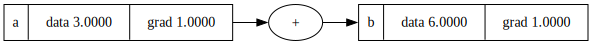

In [5]:
def lol1():
    a = Value1(3.0, _label='a')
    b = a + a; b._label = 'b'
    b.backward()
    return b
    
draw_dot(lol1())
# db/da
#    (f(x+h) - f(x)) / h 
#    ((a + h + a + h) - (a + a)) / h
#    ((2a + 2h) - 2a) / h
#    2h / h = 2
#    hence grad of a should be 2.0, but is 1.0

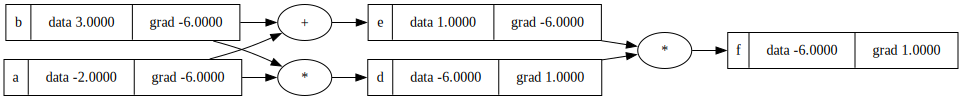

In [6]:
def lol2():
    a = Value1(-2.0, _label='a')
    b = Value1(3.0, _label='b')
    d = a * b; d._label = 'd'
    e = a + b; e._label = 'e'
    f = d * e; f._label = 'f'
    f.backward()
    return f
    
draw_dot(lol2())
# df/df is 1.0
# df/dd is 1.0
# df/de is 1.0
# df/da
#    dd/da
#      (f(x+h) - f(x)) / h 
#      (((a + h) * b) - (a * b)) / h
#      ((a*b + h*b) - a*b) / h
#      b
#      dd/da * d.grad = b * 1.0 = 3 * 1.0 = 3.0
#    +
#    de/da
#      (f(x+h) - f(x)) / h 
#      (((a + h) + b) - (a + b)) / h
#      (a + h + b - a - b) / h
#      h / h
#      de/da * e.grad = 1 * -6.0 = - 6.0
#    =
#    3.0 - 6.0 = -3.0
#    hence grad of a should be -3.0, but is 3.0

In [7]:
class Value:
    """ 
        stores a single scalar value and its gradient
        Implemented backward propagation
        Implemented programmatic backward propagation
        Fix non-accumulation of grad bug
    """
    def __init__(self, data: float, _terms=(), _op='prim', _label="?"):
        """ 
        data: a float or integer
        _terms: terms this value combines, starting with self
        _op: operation by how the terms are combined
        _label: label for self
        """
        self.data = data
        self.grad = 0 # by default 0, means initially no effect, does not effect the output. 
                      # So changing the variable does not effect the Loss function
        # internal variables used for micrograd graph construction
        #
        # the function that is doing the chain rule. How to store the output gradient 
        # into the input gradient. Propagtes the gradient
        self._backward = lambda: None; # lambda: None is the empty function, for leaf nodes.
        self._terms = set(_terms)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self._label = _label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # In the case of a + a, self and other are the same
            # instance. In that case other.grad overrides self.grad 
            # instead of accumulating. Also, if self.grad is used more 
            # than once, self.grad needs to accumlate it's former grads 
            # to itself. Hence instead of xyz.grad = 1.0 * out.grad, do
            # xyz.grad += 1.0 * out.grad
            #
            # self.grad = ???
            # the local derivative of an addition is always 1.0
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            self.grad += 1.0 * out.grad
            # other.grad = ???
            # the local derivative of an addition is always 1.0
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            # In the case of a * a, self and other are the same
            # instance. In that case other.grad overrides self.grad 
            # instead of accumulating. Also, if self.grad is used more 
            # than once, self.grad needs to accumlate it's former grads 
            # to itself. Hence instead of xyz.grad = 1.0 * out.grad, do
            # xyz.grad += 1.0 * out.grad
            # self.grad = ???
            # the local derivative of a multiplication is the data of the other multiplicant
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            self.grad += other.data * out.grad
            # other.grad = ???
            # the local derivative of a multiplication is the data of the other multiplicant
            # the global derivative is the local derivative times the 
            # already? backpropagated out grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        # See https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions
        # Hyperbolic tangent
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) 
        out = Value(t, (self,), 'tanh')
        def _backward():
            # self.grad = ???
            # the local derivative of a tanh is https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives times the 
            # already? backpropagated out grad
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the terms in the graph
        topo = []
        visited = set()
        def build_topo(v):
            # case when a term is used more than once in teh graph
            if v not in visited:
                visited.add(v)
                for term in v._terms:
                    build_topo(term)
                topo.append(v)
        build_topo(self)
        # set top term to the base grad of 1.0
        self.grad = 1
        # go one term backward at a time and apply the chain rule to get its gradient
        for v in reversed(topo):
            v._backward()
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, op={self._op}, label={self._label})"

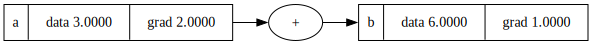

In [8]:
def lol3():
    a = Value(3.0, _label='a')
    b = a + a; b._label = 'b'
    b.backward()
    return b

# grad of a should be 2.0
draw_dot(lol3())

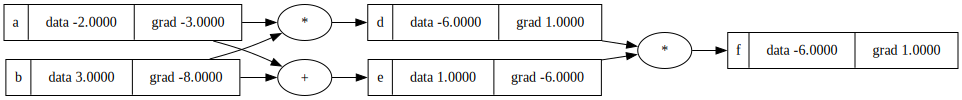

In [9]:
def lol4():
    a = Value(-2.0, _label='a')
    b = Value(3.0, _label='b')
    d = a * b; d._label = 'd'
    e = a + b; e._label = 'e'
    f = d * e; f._label = 'f'
    f.backward()
    return f

# grad of a should be -3.0
draw_dot(lol4())